In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 50#25
BS = 16

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

imagePaths1=[]
path_list=os.listdir('dataset3/PNEUMONIA+COVID')
for filename in path_list:
    imagePaths1.append(os.path.join('dataset3/PNEUMONIA+COVID',filename))

imagePaths2=[]
path_list=os.listdir('dataset3/NORMAL')
for filename in path_list:
    imagePaths2.append(os.path.join('dataset3/NORMAL',filename))


imagePaths=imagePaths1+imagePaths2
data = []
labels = []

[INFO] loading images...


In [4]:
len(imagePaths)

3182

In [5]:
# loop over the image paths
for imagePath in imagePaths:
# extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

# load the image, swap color channels, and resize it to be a fixed
# 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

# update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [6]:
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)
#print(labels)
# perform one-hot encoding on the labels
#lb = LabelBinarizer()
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [7]:

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")



baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224,3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])



print(model.summary())


# train the head of the network
print("[INFO] training head...")
H = model.fit_generator( trainAug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 

[INFO] evaluating network...
                 precision    recall  f1-score   support

         NORMAL       0.70      0.84      0.77       300
PNEUMONIA+COVID       0.83      0.68      0.75       337

       accuracy                           0.76       637
      macro avg       0.77      0.76      0.76       637
   weighted avg       0.77      0.76      0.76       637

[[253  47]
 [107 230]]
acc: 0.7582


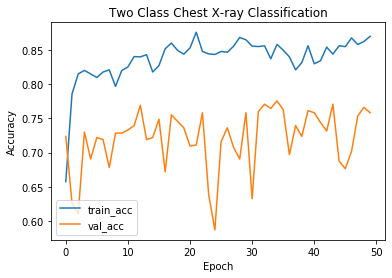

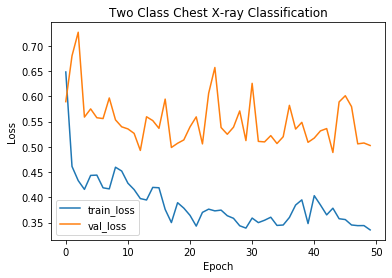

In [8]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
#acc = (cm[0, 0] + cm[1, 1] + cm[2,2]) / total
acc = (cm[0, 0] + cm[1, 1] ) / total
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))



# plot the training loss and accuracy
N = EPOCHS
plt.figure()
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Two Class Chest X-ray Classification")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plotacc")

plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Two Class Chest X-ray Classification")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plotloss")